In [1]:
# torch imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.jit import script, trace
from fastai.vision.all import *

# other python libraries 
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from math import floor
import pandas as pd
import json
from PIL import Image

In [2]:
print(f'torch version is: {torch.__version__}')

if torch.cuda.is_available():
    print('GPU is available')
else:
    print('CPU is available')
    
print(f'CUDA version is: {torch.version.cuda}')

torch version is: 1.7.1
GPU is available
CUDA version is: 11.0


In [3]:
bs = 64

In [4]:
PATH = Path('/data/disaster/labeled')

In [5]:
# define preprocessing 
transform = transforms.Compose([
    transforms.Resize((25,25)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [6]:
class ImageLoader():
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv((Path(self.root_dir)).joinpath(csv_file))
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = (Path(self.root_dir)).joinpath(self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return image, y_label
            
    "Inherit from this to have all attr accesses in `self._xtra` passed down to `self.default`"
    _default='default'
    def _component_attr_filter(self,k):
        if k.startswith('__') or k in ('_xtra',self._default): return False
        xtra = getattr(self,'_xtra',None)
        return xtra is None or k in xtra
    def _dir(self): return [k for k in dir(getattr(self,self._default)) if self._component_attr_filter(k)]
    def __getattr__(self,k):
        if self._component_attr_filter(k):
            attr = getattr(self,self._default,None)
            if attr is not None: return getattr(attr,k)
        raise AttributeError(k)
    def __dir__(self): return custom_dir(self,self._dir())
#     def __getstate__(self): return self.__dict__
    def __setstate__(self,data): self.__dict__.update(data)
    
    def delegate_attr(self, k, to):
        "Use in `__getattr__` to delegate to attr `to` without inheriting from `GetAttr`"
        if k.startswith('_') or k==to: raise AttributeError(k)
        try: return getattr(getattr(self,to), k)
        except AttributeError: raise AttributeError(k) from None

In [7]:
train_set = ImageLoader(PATH, 'train.csv', transform=transform)
test_set = ImageLoader(PATH, 'test.csv', transform=transform)

In [8]:
len(train_set), len(test_set)

(38694, 9674)

In [9]:
train_set[0][0].shape

torch.Size([3, 25, 25])

In [10]:
train_loader = DataLoader(train_set, batch_size = bs, shuffle = True)

test_loader = DataLoader(train_set, batch_size = bs, shuffle = True)

In [11]:
# use fastai
data = DataLoaders(train_loader, test_loader)

In [12]:
def conv_output(n_in, p, k, s):
    '''
    n_in: number of input features 
    n_out: number of output features
    k: convolution kernel size
    p: convolution padding size
    s: convolution stride size
    '''
    n_out = floor((n_in + 2*p - k) / s) + 1
    return n_out

In [13]:
# img_size = (64, 3, 25, 25)

# Identity function 1, 3, 25, 25
# Convolution 1, 6, 21, 21
# Max Pooling 1, 6, 10, 10
# Convolution 1, 12, 6, 6
# Max Pooling 1, 12, 3, 3

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) 
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12 * 3 * 3, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=4)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
net = Net()

In [16]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=108, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=4, bias=True)
)

In [17]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 3, 5, 5])


In [18]:
# pytorch training loop
def train(EPOCHS, criterion=nn.CrossEntropyLoss(), optimizer=optim.SGD(net.parameters(), lr=0.01)):
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    net.to(device)
    
    train_loss = 0.0
    
    for epoch in range(1, EPOCHS+1):
        for (inputs, targets) in tqdm(train_loader, desc='train', colour='green'): 
            inputs, targets = inputs.to(device), targets.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            pred = net(inputs)
            # calculate loss
            loss = criterion(pred, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            train_loss = loss.item() * inputs.size(0)
            
        with torch.no_grad():
            for (inputs, targets) in tqdm(test_loader, desc='test', colour='green'):
                inputs, targets = inputs.to(device), targets.to(device) 
                # compute the model output
                pred = net(inputs)
                # calculate loss
                loss = criterion(pred, targets)
                test_loss = loss.item() * inputs.size(0)
        
        print(f'Epoch {epoch} / {EPOCHS} \t\t Training Loss: {round(train_loss / len(train_loader),3)} \t\t Test Loss: {round(test_loss / len(test_loader),3)}')

In [19]:
learn = Learner(data, net, loss_func=nn.CrossEntropyLoss(), opt_func=Adam, metrics=accuracy, 
                cbs=ShowGraphCallback()) 

epoch,train_loss,valid_loss,accuracy,time
0,0.654625,0.602263,0.794361,00:33
1,0.399399,0.396788,0.855378,00:33


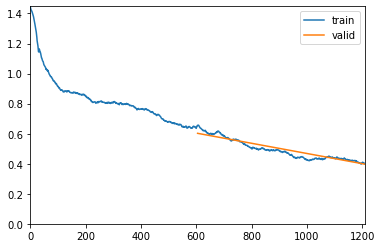

In [20]:
# fastai training loop
learn.fit_one_cycle(2, 0.01)